In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join('../..'))

if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import numpy as np
import pandas as pd
from collections import defaultdict

# <center>Computational Mathematics Report Experiments</center>
## <center>Support Vector Classifier</center>
### <center>Donato Meoli</center>
##### <center>d.meoli@studenti.unipi.it</center>

<center>Computational Mathematics course 646AA</center>
<center>Academic year: 2019/2020</center>

<center>Type of project: Wildcard #5 with Machine Learning</center>
<center>Group 35</center>

In [49]:
def filter_svc_cv_results(cv_results):
    
    filtered_cv_results = pd.DataFrame()
    
    if 'param_optimizer' in cv_results.columns:
        
        filtered_cv_results['solver'] = cv_results['param_optimizer']
    
    if 'param_reg_intercept' in cv_results.columns:
        
        filtered_cv_results['dual'] = cv_results['param_reg_intercept']
        filtered_cv_results['dual'] = filtered_cv_results['dual'].replace(True, 'reg_bias')
        filtered_cv_results['dual'] = filtered_cv_results['dual'].replace(False, 'unreg_bias')
    
    if 'param_kernel' in cv_results.columns:
        
        filtered_cv_results['kernel'] = cv_results['param_kernel']
        filtered_cv_results['kernel'] = filtered_cv_results['kernel'].astype(str).str.replace(r'(^.*PolyKernel.*$)', 'poly', regex=True)
        filtered_cv_results['kernel'] = filtered_cv_results['kernel'].astype(str).str.replace(r'(^.*GaussianKernel.*$)', 'rbf', regex=True)
    
    filtered_cv_results[['C', 'fit_time', 'accuracy', 'n_iter']] = cv_results[[
        'param_C', 'mean_fit_time', 'mean_train_accuracy', 'mean_train_n_iter']]
    
    filtered_cv_results['n_iter'] = filtered_cv_results['n_iter'].round().astype(int)

    filtered_cv_results['n_sv'] = cv_results['mean_train_n_sv'].round().astype(int)

    return filtered_cv_results

In [50]:
from optiml.ml.utils import generate_linearly_separable_overlap_data, generate_nonlinearly_separable_data

lin_X, lin_y = generate_linearly_separable_overlap_data(random_state=123456)
nonlin_X, nonlin_y = generate_nonlinearly_separable_data(random_state=123456)

## Hinge loss

### Primal formulation

In [51]:
from optiml.ml.svm import PrimalSVC
from optiml.ml.svm.losses import hinge
from optiml.ml.utils import plot_svm_hyperplane, plot_model_loss

from optiml.opti.unconstrained.stochastic import StochasticGradientDescent
from optiml.opti.utils import plot_surface_contour, plot_trajectory_optimization

from sklearn.svm import LinearSVC as SkLinearSVC
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

In [52]:
train_loss_history = defaultdict(dict)

def primal_accuracy_scorer(svc, X, y):
    
    if hasattr(svc, 'train_loss_history'):
        
        from optiml.ml.svm import DualSVC
        from optiml.ml.svm.kernels import LinearKernel
        
        dual_svc = DualSVC(loss=hinge, 
                           kernel=LinearKernel(), 
                           C=svc.C, 
                           reg_intercept=True, 
                           optimizer='cvxopt').fit(lin_X, lin_y)
        f_star = np.full_like(svc.train_loss_history, svc.loss(np.append(dual_svc.coef_, dual_svc.intercept_)))
        # (f_t - f^*) / f^*
        train_loss_history[svc.momentum_type][svc.C] = np.divide((svc.train_loss_history - f_star), 
                                                                 np.maximum(abs(f_star), 1))
        
    return {'accuracy': svc.score(X, y),
            'n_iter': svc.n_iter_ if isinstance(svc, SkLinearSVC) else svc.optimizer.iter + 1,  # starts from 0
            'n_sv': len(np.argwhere(np.abs(svc.decision_function(lin_X)) <= 1).ravel())}

Fitting 1 folds for each of 3 candidates, totalling 3 fits
     pcost       dcost       gap    pres   dres
 0: -3.8628e+01 -4.0156e+02  2e+03  3e+00  2e-14
 1: -2.4099e+01 -2.2235e+02  4e+02  3e-01  1e-14
 2: -1.3880e+01 -4.8120e+01  6e+01  5e-02  1e-14
 3: -1.1134e+01 -2.1089e+01  1e+01  1e-02  8e-15
 4: -1.1231e+01 -1.5245e+01  5e+00  3e-03  6e-15
 5: -1.1547e+01 -1.3005e+01  2e+00  8e-04  5e-15
 6: -1.1843e+01 -1.2109e+01  3e-01  2e-05  6e-15
 7: -1.1951e+01 -1.1972e+01  2e-02  2e-06  5e-15
 8: -1.1960e+01 -1.1962e+01  2e-03  2e-16  6e-15
 9: -1.1961e+01 -1.1961e+01  2e-05  2e-16  6e-15
10: -1.1961e+01 -1.1961e+01  2e-07  2e-16  6e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -3.8628e+01 -4.0156e+02  2e+03  3e+00  2e-14
 1: -2.4099e+01 -2.2235e+02  4e+02  3e-01  1e-14
 2: -1.3880e+01 -4.8120e+01  6e+01  5e-02  1e-14
 3: -1.1134e+01 -2.1089e+01  1e+01  1e-02  8e-15
 4: -1.1231e+01 -1.5245e+01  5e+00  3e-03  6e-15
 5: -1.1547e+01 -1.3005e+01  2e+00  8

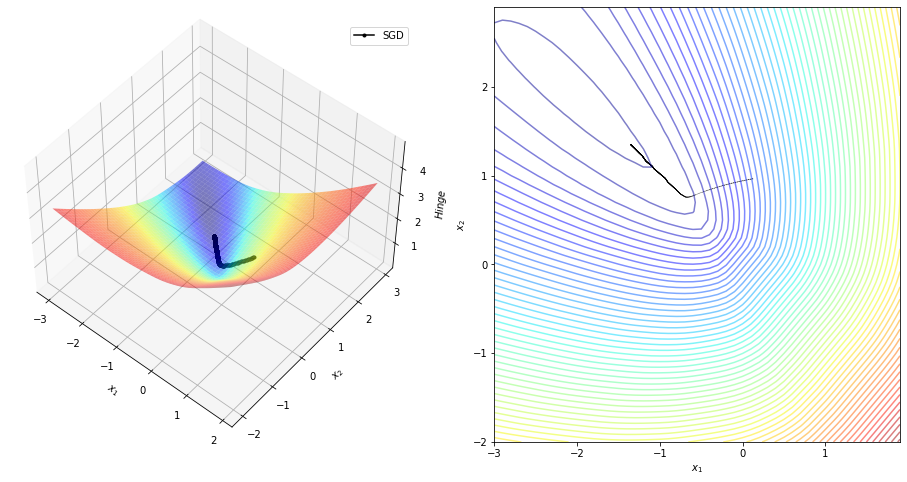

In [53]:
grid = GridSearchCV(PrimalSVC(loss=hinge, 
                              optimizer=StochasticGradientDescent, 
                              learning_rate=0.02, 
                              momentum_type='none', 
                              early_stopping=True, 
                              tol=1e-8, 
                              random_state=123456),
                    param_grid={'C': [1, 10, 100]},
                    scoring=primal_accuracy_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=1,  # 'train_loss_history' is not thread safe
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

grid.best_estimator_.loss.X = grid.best_estimator_.loss.X[:, :-1]  # remove the intercept column to plot in 2D
hinge_loss = plot_surface_contour(grid.best_estimator_.loss, 
                                  x_min=-3, x_max=2, y_min=-2, y_max=3)
hinge_loss_opt = plot_trajectory_optimization(hinge_loss, 
                                              grid.best_estimator_.optimizer, 
                                              color='k', 
                                              label='SGD')

In [54]:
none_primal_svc_hinge_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
none_primal_svc_hinge_cv_results.insert(0, 'solver', 'sgd')
none_primal_svc_hinge_cv_results.insert(1, 'momentum', 'none')
none_primal_svc_hinge_cv_results.set_index(['solver', 'momentum', 'C'], inplace=True)
none_primal_svc_hinge_cv_results

fit_time  accuracy  n_iter  n_sv
solver momentum C                                    
sgd    none     1    0.389469     0.985    1000    24
                10   0.403823     0.980     947    10
                100  0.140838     0.985     214     7

Fitting 1 folds for each of 3 candidates, totalling 3 fits
     pcost       dcost       gap    pres   dres
 0: -3.8628e+01 -4.0156e+02  2e+03  3e+00  2e-14
 1: -2.4099e+01 -2.2235e+02  4e+02  3e-01  1e-14
 2: -1.3880e+01 -4.8120e+01  6e+01  5e-02  1e-14
 3: -1.1134e+01 -2.1089e+01  1e+01  1e-02  8e-15
 4: -1.1231e+01 -1.5245e+01  5e+00  3e-03  6e-15
 5: -1.1547e+01 -1.3005e+01  2e+00  8e-04  5e-15
 6: -1.1843e+01 -1.2109e+01  3e-01  2e-05  6e-15
 7: -1.1951e+01 -1.1972e+01  2e-02  2e-06  5e-15
 8: -1.1960e+01 -1.1962e+01  2e-03  2e-16  6e-15
 9: -1.1961e+01 -1.1961e+01  2e-05  2e-16  6e-15
10: -1.1961e+01 -1.1961e+01  2e-07  2e-16  6e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -3.8628e+01 -4.0156e+02  2e+03  3e+00  2e-14
 1: -2.4099e+01 -2.2235e+02  4e+02  3e-01  1e-14
 2: -1.3880e+01 -4.8120e+01  6e+01  5e-02  1e-14
 3: -1.1134e+01 -2.1089e+01  1e+01  1e-02  8e-15
 4: -1.1231e+01 -1.5245e+01  5e+00  3e-03  6e-15
 5: -1.1547e+01 -1.3005e+01  2e+00  8

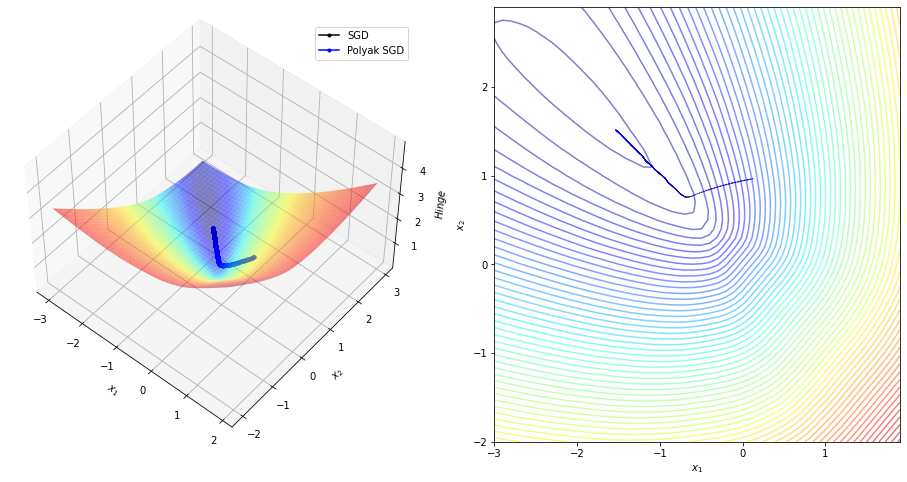

In [55]:
grid = GridSearchCV(PrimalSVC(loss=hinge, 
                              optimizer=StochasticGradientDescent, 
                              learning_rate=0.02, 
                              momentum_type='polyak', 
                              momentum=0.4, 
                              early_stopping=True, 
                              tol=1e-8, 
                              random_state=123456),
                    param_grid={'C': [1, 10, 100]},
                    scoring=primal_accuracy_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=1,  # 'train_loss_history' is not thread safe
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

hinge_loss_opt = plot_trajectory_optimization(hinge_loss_opt, 
                                              grid.best_estimator_.optimizer, 
                                              color='b', 
                                              label='Polyak SGD')
hinge_loss_opt

In [56]:
polyak_primal_svc_hinge_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
polyak_primal_svc_hinge_cv_results.insert(0, 'solver', 'sgd')
polyak_primal_svc_hinge_cv_results.insert(1, 'momentum', 'polyak')
polyak_primal_svc_hinge_cv_results.set_index(['solver', 'momentum', 'C'], inplace=True)
polyak_primal_svc_hinge_cv_results

fit_time  accuracy  n_iter  n_sv
solver momentum C                                    
sgd    polyak   1    0.360443     0.985    1000    19
                10   0.287775     0.980     567    10
                100  0.053898     0.985      44     6

Fitting 1 folds for each of 3 candidates, totalling 3 fits
     pcost       dcost       gap    pres   dres
 0: -3.8628e+01 -4.0156e+02  2e+03  3e+00  2e-14
 1: -2.4099e+01 -2.2235e+02  4e+02  3e-01  1e-14
 2: -1.3880e+01 -4.8120e+01  6e+01  5e-02  1e-14
 3: -1.1134e+01 -2.1089e+01  1e+01  1e-02  8e-15
 4: -1.1231e+01 -1.5245e+01  5e+00  3e-03  6e-15
 5: -1.1547e+01 -1.3005e+01  2e+00  8e-04  5e-15
 6: -1.1843e+01 -1.2109e+01  3e-01  2e-05  6e-15
 7: -1.1951e+01 -1.1972e+01  2e-02  2e-06  5e-15
 8: -1.1960e+01 -1.1962e+01  2e-03  2e-16  6e-15
 9: -1.1961e+01 -1.1961e+01  2e-05  2e-16  6e-15
10: -1.1961e+01 -1.1961e+01  2e-07  2e-16  6e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -3.8628e+01 -4.0156e+02  2e+03  3e+00  2e-14
 1: -2.4099e+01 -2.2235e+02  4e+02  3e-01  1e-14
 2: -1.3880e+01 -4.8120e+01  6e+01  5e-02  1e-14
 3: -1.1134e+01 -2.1089e+01  1e+01  1e-02  8e-15
 4: -1.1231e+01 -1.5245e+01  5e+00  3e-03  6e-15
 5: -1.1547e+01 -1.3005e+01  2e+00  8

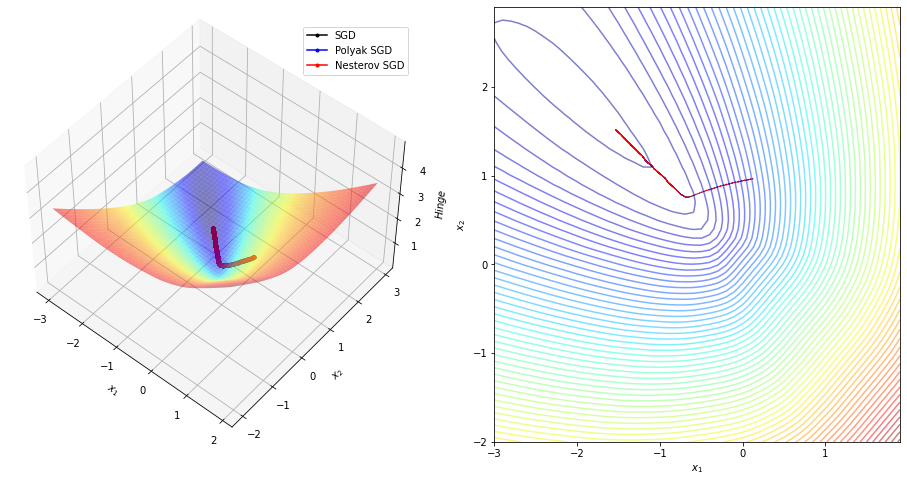

In [57]:
grid = GridSearchCV(PrimalSVC(loss=hinge, 
                              optimizer=StochasticGradientDescent, 
                              learning_rate=0.02, 
                              momentum_type='nesterov', 
                              momentum=0.4, 
                              early_stopping=True, 
                              tol=1e-8, 
                              random_state=123456),
                    param_grid={'C': [1, 10, 100]},
                    scoring=primal_accuracy_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=1,  # 'train_loss_history' is not thread safe
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

hinge_loss_opt = plot_trajectory_optimization(hinge_loss_opt, 
                                              grid.best_estimator_.optimizer, 
                                              color='r', 
                                              label='Nesterov SGD')
hinge_loss_opt.savefig('./tex/img/l1_svc_loss.png')
hinge_loss_opt

In [58]:
nesterov_primal_svc_hinge_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
nesterov_primal_svc_hinge_cv_results.insert(0, 'solver', 'sgd')
nesterov_primal_svc_hinge_cv_results.insert(1, 'momentum', 'nesterov')
nesterov_primal_svc_hinge_cv_results.set_index(['solver', 'momentum', 'C'], inplace=True)
nesterov_primal_svc_hinge_cv_results

fit_time  accuracy  n_iter  n_sv
solver momentum C                                    
sgd    nesterov 1    0.365003     0.985    1000    20
                10   0.295522     0.980     569    10
                100  0.068258     0.985      42     6

In [59]:
custom_primal_svc_hinge_cv_results = none_primal_svc_hinge_cv_results.append(
    polyak_primal_svc_hinge_cv_results).append(
    nesterov_primal_svc_hinge_cv_results)
custom_primal_svc_hinge_cv_results

fit_time  accuracy  n_iter  n_sv
solver momentum C                                    
sgd    none     1    0.389469     0.985    1000    24
                10   0.403823     0.980     947    10
                100  0.140838     0.985     214     7
       polyak   1    0.360443     0.985    1000    19
                10   0.287775     0.980     567    10
                100  0.053898     0.985      44     6
       nesterov 1    0.365003     0.985    1000    20
                10   0.295522     0.980     569    10
                100  0.068258     0.985      42     6

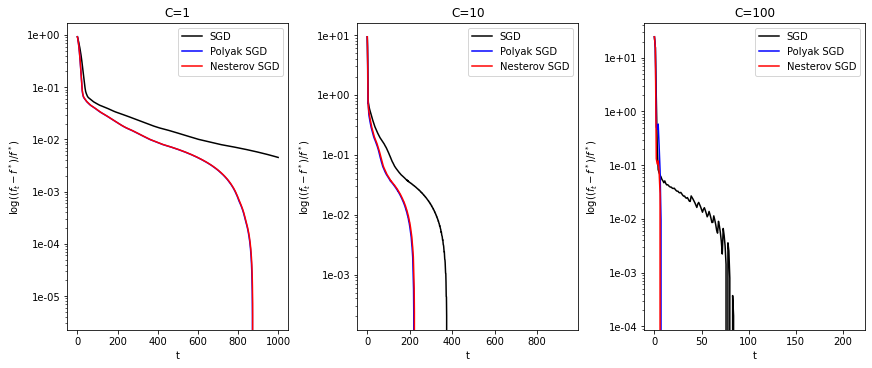

In [60]:
colors = {'none': ('k', 'SGD'),
          'polyak': ('b', 'Polyak SGD'),
          'nesterov': ('r', 'Nesterov SGD')}
axes = plt.figure(figsize=(12, 5), constrained_layout=True).subplots(1, 3)
for momentum, _dict in train_loss_history.items():
    for (C, history), loss in zip(_dict.items(), axes):
        loss.plot(history, color=colors[momentum][0], label=colors[momentum][1])
        loss.set_title('C={:d}'.format(C))
        loss.set_xlabel('t')
        loss.set_yscale('log')
        loss.set_ylabel('$\log((f_t - f^*) / f^*)$')
        loss.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
        loss.legend().get_frame().set_facecolor('white')
plt.savefig('./tex/img/l1_svc_loss_history.png')

In [61]:
grid = GridSearchCV(SkLinearSVC(loss='hinge', 
                                random_state=123456),
                    param_grid={'C': [1, 10, 100]},
                    scoring=primal_accuracy_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

Fitting 1 folds for each of 3 candidates, totalling 3 fits


In [62]:
liblinear_primal_svc_hinge_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
liblinear_primal_svc_hinge_cv_results.insert(0, 'solver', 'liblinear')
liblinear_primal_svc_hinge_cv_results.insert(1, 'momentum', '-')
liblinear_primal_svc_hinge_cv_results.set_index(['solver', 'momentum', 'C'], inplace=True)
liblinear_primal_svc_hinge_cv_results

fit_time  accuracy  n_iter  n_sv
solver    momentum C                                    
liblinear -        1    0.001138     0.985     332    16
                   10   0.001744     0.985    1000     5
                   100  0.001817     0.985    1000     6

In [63]:
primal_svc_hinge_cv_results = custom_primal_svc_hinge_cv_results.append(liblinear_primal_svc_hinge_cv_results)
primal_svc_hinge_cv_results.to_latex('./tex/experiments/primal_l1_svc.tex', 
                                     caption='Primal $\protect \mathcal{L}_1$-SVC results', 
                                     label='primal_l1_svc_cv_results', position='H')
primal_svc_hinge_cv_results

fit_time  accuracy  n_iter  n_sv
solver    momentum C                                    
sgd       none     1    0.389469     0.985    1000    24
                   10   0.403823     0.980     947    10
                   100  0.140838     0.985     214     7
          polyak   1    0.360443     0.985    1000    19
                   10   0.287775     0.980     567    10
                   100  0.053898     0.985      44     6
          nesterov 1    0.365003     0.985    1000    20
                   10   0.295522     0.980     569    10
                   100  0.068258     0.985      42     6
liblinear -        1    0.001138     0.985     332    16
                   10   0.001744     0.985    1000     5
                   100  0.001817     0.985    1000     6

### Dual formulations

In [64]:
from optiml.ml.svm import DualSVC
from optiml.ml.svm.losses import hinge
from optiml.ml.svm.kernels import LinearKernel, PolyKernel, GaussianKernel
from optiml.ml.utils import plot_svm_hyperplane

from optiml.opti.constrained._base import LagrangianQuadratic
from optiml.opti.unconstrained.stochastic import AdaGrad

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

In [65]:
import re
from io import StringIO
from wurlitzer import pipes, STDOUT


class SklSVC(SVC):

    def fit(self, X, y, sample_weight=None):
        out = StringIO()
        with pipes(stdout=out, stderr=STDOUT):
            super().fit(X, y, sample_weight)
        self.n_iter_ = int(re.findall(r'%s(\d+)' % '#iter = ', out.getvalue())[0])
        return self

In [66]:
train_loss_history = defaultdict(lambda: defaultdict(dict))

def dual_accuracy_scorer(svc, X, y):
    
    if(hasattr(svc, 'train_loss_history') and
                isinstance(svc.obj, LagrangianQuadratic)):
        
        dual_svc = DualSVC(loss=hinge, 
                           kernel=svc.kernel, 
                           C=svc.C, 
                           reg_intercept=svc.reg_intercept, 
                           optimizer='cvxopt')
        if isinstance(svc.kernel, LinearKernel):
            dual_svc.fit(lin_X, lin_y)
        else:
            dual_svc.fit(nonlin_X, nonlin_y)
        f_star = np.full_like(svc.train_loss_history, dual_svc.obj(dual_svc.alphas_))
        # (f_t - f^*) / f^*
        dual = 'reg_bias' if svc.reg_intercept else 'unreg_bias'
        train_loss_history[dual][svc.kernel.__class__.__name__][svc.C] = np.divide((svc.train_loss_history - f_star), 
                                                                                   np.maximum(abs(f_star), 1))
        
    return {'accuracy': svc.score(X, y), 
            'n_iter': svc.n_iter_ if isinstance(svc, SklSVC) else (svc.iter if isinstance(svc.optimizer, str) 
                                                                   else svc.optimizer.iter) + 1,  # starts from 0
            'n_sv': len(svc.support_)}

#### Wolfe Dual

##### Linear

Fitting 1 folds for each of 6 candidates, totalling 6 fits


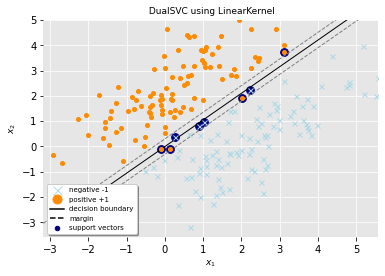

In [67]:
grid = GridSearchCV(DualSVC(loss=hinge, 
                            kernel=LinearKernel()),
                    param_grid={'C': [1, 10, 100],
                                'optimizer': ['smo', 'cvxopt']},
                    scoring=dual_accuracy_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

plot_svm_hyperplane(grid.best_estimator_, lin_X, lin_y)
plt.savefig('./tex/img/linear_dual_l1_svc_hyperplane.png')

In [68]:
custom_linear_dual_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
custom_linear_dual_svc_cv_results.sort_values(['solver'], inplace=True)
custom_linear_dual_svc_cv_results.set_index(['solver', 'C'], inplace=True)
custom_linear_dual_svc_cv_results

fit_time  accuracy  n_iter  n_sv
solver C                                    
cvxopt 1    0.033754     0.980      10    17
       10   0.026945     0.980      10    11
       100  0.047614     0.980      10    12
smo    1    0.073731     0.980      62    17
       10   0.146260     0.980     295    10
       100  0.160641     0.985     399     8

In [69]:
grid = GridSearchCV(SklSVC(kernel='linear', 
                           verbose=True),  # `verbose=True` to capture n_iter
                    param_grid={'C': [1, 10, 100]},
                    scoring=dual_accuracy_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

Fitting 1 folds for each of 3 candidates, totalling 3 fits
[LibSVM]

In [70]:
libsvm_linear_dual_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
libsvm_linear_dual_svc_cv_results.insert(0, 'solver', 'libsvm')
libsvm_linear_dual_svc_cv_results.set_index(['solver', 'C'], inplace=True)
libsvm_linear_dual_svc_cv_results

fit_time  accuracy  n_iter  n_sv
solver C                                    
libsvm 1    0.003538     0.985     243    17
       10   0.002517     0.985     194    10
       100  0.002370     0.985    1602     8

In [71]:
linear_dual_svc_cv_results = custom_linear_dual_svc_cv_results.append(libsvm_linear_dual_svc_cv_results)
linear_dual_svc_cv_results.sort_values(['solver'], ascending=False, inplace=True)
linear_dual_svc_cv_results.to_latex('./tex/experiments/linear_dual_l1_svc.tex', 
                                    caption='Wolfe Dual linear $\protect \mathcal{L}_1$-SVC results', 
                                    label='linear_dual_l1_svc_cv_results', position='H')
linear_dual_svc_cv_results

fit_time  accuracy  n_iter  n_sv
solver C                                    
smo    1    0.073731     0.980      62    17
       10   0.146260     0.980     295    10
       100  0.160641     0.985     399     8
libsvm 1    0.003538     0.985     243    17
       10   0.002517     0.985     194    10
       100  0.002370     0.985    1602     8
cvxopt 1    0.033754     0.980      10    17
       10   0.026945     0.980      10    11
       100  0.047614     0.980      10    12

##### Nonlinear

Fitting 1 folds for each of 6 candidates, totalling 6 fits


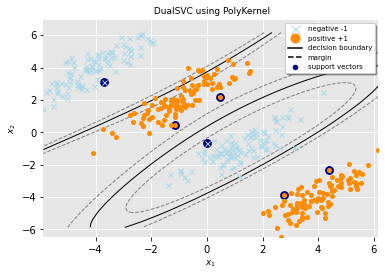

In [72]:
grid = GridSearchCV(DualSVC(loss=hinge),
                    param_grid={'C': [1, 10, 100],
                                'kernel': [PolyKernel(degree=3, coef0=1, gamma='scale')],
                                'optimizer': ['smo', 'cvxopt']},
                    scoring=dual_accuracy_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(nonlin_X, nonlin_y)

plot_svm_hyperplane(grid.best_estimator_, nonlin_X, nonlin_y)
plt.savefig('./tex/img/poly_dual_l1_svc_hyperplane.png')

In [73]:
poly_nonlinear_dual_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
poly_nonlinear_dual_svc_cv_results.sort_values(['solver'], inplace=True)
poly_nonlinear_dual_svc_cv_results.set_index(['solver', 'kernel', 'C'], inplace=True)
poly_nonlinear_dual_svc_cv_results

fit_time  accuracy  n_iter  n_sv
solver kernel C                                    
cvxopt poly   1    0.263280    0.6775      10    31
              10   0.320027    0.9475      10    10
              100  0.316199    0.9775      10     6
smo    poly   1    0.331230    0.6825     143    30
              10   0.222763    0.9475      65    10
              100  0.183422    0.9775      38     6

Fitting 1 folds for each of 6 candidates, totalling 6 fits


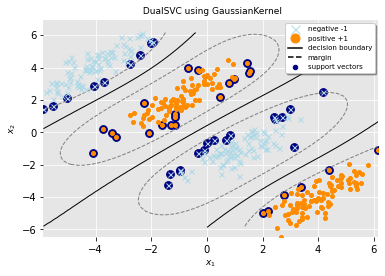

In [74]:
grid = GridSearchCV(DualSVC(loss=hinge),
                    param_grid={'C': [1, 10, 100],
                                'kernel': [GaussianKernel(gamma='scale')],
                                'optimizer': ['smo', 'cvxopt']},
                    scoring=dual_accuracy_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(nonlin_X, nonlin_y)

plot_svm_hyperplane(grid.best_estimator_, nonlin_X, nonlin_y)
plt.savefig('./tex/img/gaussian_dual_l1_svc_hyperplane.png')

In [75]:
rbf_nonlinear_dual_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
rbf_nonlinear_dual_svc_cv_results.sort_values(['solver'], inplace=True)
rbf_nonlinear_dual_svc_cv_results.set_index(['solver', 'kernel', 'C'], inplace=True)
rbf_nonlinear_dual_svc_cv_results

fit_time  accuracy  n_iter  n_sv
solver kernel C                                    
cvxopt rbf    1    0.275124       1.0      10    49
              10   0.274324       1.0      10    14
              100  0.263167       1.0      10    17
smo    rbf    1    0.354633       1.0      66    51
              10   0.236538       1.0      38    13
              100  0.261990       1.0      56    12

In [76]:
custom_nonlinear_dual_svc_cv_results = poly_nonlinear_dual_svc_cv_results.append(rbf_nonlinear_dual_svc_cv_results)
custom_nonlinear_dual_svc_cv_results.sort_values(['solver', 'kernel'], inplace=True)
custom_nonlinear_dual_svc_cv_results

fit_time  accuracy  n_iter  n_sv
solver kernel C                                    
cvxopt poly   1    0.263280    0.6775      10    31
              10   0.320027    0.9475      10    10
              100  0.316199    0.9775      10     6
       rbf    1    0.275124    1.0000      10    49
              10   0.274324    1.0000      10    14
              100  0.263167    1.0000      10    17
smo    poly   1    0.331230    0.6825     143    30
              10   0.222763    0.9475      65    10
              100  0.183422    0.9775      38     6
       rbf    1    0.354633    1.0000      66    51
              10   0.236538    1.0000      38    13
              100  0.261990    1.0000      56    12

In [77]:
grid = GridSearchCV(SklSVC(verbose=True),  # `verbose=True` to capture n_iter
                    param_grid=[{'C': [1, 10, 100],
                                 'kernel': ['poly'],
                                 'degree': [3],
                                 'coef0': [1],
                                 'gamma': ['scale']},
                                {'C': [1, 10, 100],
                                 'kernel': ['rbf'],
                                 'gamma': ['scale']}],
                    scoring=dual_accuracy_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(nonlin_X, nonlin_y)

Fitting 1 folds for each of 6 candidates, totalling 6 fits
[LibSVM]

In [78]:
libsvm_nonlinear_dual_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
libsvm_nonlinear_dual_svc_cv_results.insert(0, 'solver', 'libsvm')
libsvm_nonlinear_dual_svc_cv_results.sort_values(['kernel'], inplace=True)
libsvm_nonlinear_dual_svc_cv_results.set_index(['solver', 'kernel', 'C'], inplace=True)
libsvm_nonlinear_dual_svc_cv_results

fit_time  accuracy  n_iter  n_sv
solver kernel C                                    
libsvm poly   1    0.004080       1.0     233    30
              10   0.003118       1.0     118    10
              100  0.002584       1.0      88     6
       rbf    1    0.005674       1.0     252    50
              10   0.002344       1.0     134    13
              100  0.003012       1.0     182    12

In [79]:
nonlinear_dual_svc_cv_results = custom_nonlinear_dual_svc_cv_results.append(libsvm_nonlinear_dual_svc_cv_results)
nonlinear_dual_svc_cv_results.sort_values(['solver', 'kernel'], ascending=[False, True], inplace=True)
nonlinear_dual_svc_cv_results.to_latex('./tex/experiments/nonlinear_dual_l1_svc.tex', 
                                       caption='Wolfe Dual nonlinear $\protect \mathcal{L}_1$-SVC results', 
                                       label='nonlinear_dual_l1_svc_cv_results', position='H')
nonlinear_dual_svc_cv_results

fit_time  accuracy  n_iter  n_sv
solver kernel C                                    
smo    poly   1    0.331230    0.6825     143    30
              10   0.222763    0.9475      65    10
              100  0.183422    0.9775      38     6
       rbf    1    0.354633    1.0000      66    51
              10   0.236538    1.0000      38    13
              100  0.261990    1.0000      56    12
libsvm poly   1    0.004080    1.0000     233    30
              10   0.003118    1.0000     118    10
              100  0.002584    1.0000      88     6
       rbf    1    0.005674    1.0000     252    50
              10   0.002344    1.0000     134    13
              100  0.003012    1.0000     182    12
cvxopt poly   1    0.263280    0.6775      10    31
              10   0.320027    0.9475      10    10
              100  0.316199    0.9775      10     6
       rbf    1    0.275124    1.0000      10    49
              10   0.274324    1.0000      10    14
              100  0.263167    1.0000      10    17

#### Lagrangian Dual

##### Linear

Fitting 1 folds for each of 6 candidates, totalling 6 fits


/home/donato/Insync/donato.meoli.95@gmail.com/Google Drive/MachineLearning&ComputationalMathematics/optiml/optiml/ml/svm/_base.py:845: ConvergenceWarning: max_iter reached but the optimization has not converged yet
  warnings.warn('max_iter reached but the optimization has not converged yet',


     pcost       dcost       gap    pres   dres
 0: -3.8628e+01 -4.0156e+02  2e+03  3e+00  2e-14
 1: -2.4099e+01 -2.2235e+02  4e+02  3e-01  1e-14
 2: -1.3880e+01 -4.8120e+01  6e+01  5e-02  1e-14
 3: -1.1134e+01 -2.1089e+01  1e+01  1e-02  8e-15
 4: -1.1231e+01 -1.5245e+01  5e+00  3e-03  6e-15
 5: -1.1547e+01 -1.3005e+01  2e+00  8e-04  5e-15
 6: -1.1843e+01 -1.2109e+01  3e-01  2e-05  6e-15
 7: -1.1951e+01 -1.1972e+01  2e-02  2e-06  5e-15
 8: -1.1960e+01 -1.1962e+01  2e-03  2e-16  6e-15
 9: -1.1961e+01 -1.1961e+01  2e-05  2e-16  6e-15
10: -1.1961e+01 -1.1961e+01  2e-07  2e-16  6e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -3.8628e+01 -4.0156e+02  2e+03  3e+00  2e-14
 1: -2.4099e+01 -2.2235e+02  4e+02  3e-01  1e-14
 2: -1.3880e+01 -4.8120e+01  6e+01  5e-02  1e-14
 3: -1.1134e+01 -2.1089e+01  1e+01  1e-02  8e-15
 4: -1.1231e+01 -1.5245e+01  5e+00  3e-03  6e-15
 5: -1.1547e+01 -1.3005e+01  2e+00  8e-04  5e-15
 6: -1.1843e+01 -1.2109e+01  3e-01  2e-05  6e-1

/home/donato/Insync/donato.meoli.95@gmail.com/Google Drive/MachineLearning&ComputationalMathematics/optiml/optiml/ml/svm/_base.py:845: ConvergenceWarning: max_iter reached but the optimization has not converged yet
  warnings.warn('max_iter reached but the optimization has not converged yet',


     pcost       dcost       gap    pres   dres
 0: -3.8628e+01 -4.0156e+02  2e+03  3e+00  2e-14
 1: -2.4099e+01 -2.2236e+02  4e+02  3e-01  1e-14
 2: -1.3927e+01 -4.9045e+01  6e+01  5e-02  1e-14
 3: -1.1108e+01 -2.1360e+01  2e+01  1e-02  7e-15
 4: -1.1175e+01 -1.5591e+01  6e+00  3e-03  6e-15
 5: -1.1464e+01 -1.3469e+01  2e+00  1e-03  4e-15
 6: -1.1758e+01 -1.2304e+01  6e-01  2e-04  5e-15
 7: -1.1894e+01 -1.2019e+01  1e-01  4e-05  5e-15
 8: -1.1927e+01 -1.1953e+01  3e-02  3e-15  5e-15
 9: -1.1939e+01 -1.1940e+01  3e-04  7e-16  5e-15
10: -1.1940e+01 -1.1940e+01  3e-06  1e-15  5e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -3.8628e+01 -4.0156e+02  2e+03  3e+00  2e-14
 1: -2.4099e+01 -2.2236e+02  4e+02  3e-01  1e-14
 2: -1.3927e+01 -4.9045e+01  6e+01  5e-02  1e-14
 3: -1.1108e+01 -2.1360e+01  2e+01  1e-02  7e-15
 4: -1.1175e+01 -1.5591e+01  6e+00  3e-03  6e-15
 5: -1.1464e+01 -1.3469e+01  2e+00  1e-03  4e-15
 6: -1.1758e+01 -1.2304e+01  6e-01  2e-04  5e-1

/home/donato/Insync/donato.meoli.95@gmail.com/Google Drive/MachineLearning&ComputationalMathematics/optiml/optiml/ml/svm/_base.py:845: ConvergenceWarning: max_iter reached but the optimization has not converged yet
  warnings.warn('max_iter reached but the optimization has not converged yet',


     pcost       dcost       gap    pres   dres
 0: -1.9646e+02 -1.3070e+04  4e+04  8e-01  1e-13
 1: -8.5838e+01 -3.2743e+03  5e+03  8e-02  8e-14
 2: -2.0411e+01 -5.4922e+02  8e+02  1e-02  8e-14
 3: -4.5109e+01 -1.6962e+02  1e+02  2e-03  3e-14
 4: -6.0065e+01 -1.1094e+02  6e+01  6e-04  3e-14
 5: -6.4282e+01 -1.0889e+02  5e+01  4e-04  4e-14
 6: -6.9109e+01 -9.4808e+01  3e+01  3e-05  4e-14
 7: -7.1902e+01 -9.0981e+01  2e+01  2e-05  3e-14
 8: -7.8973e+01 -8.1360e+01  2e+00  2e-07  5e-14
 9: -7.9748e+01 -7.9821e+01  7e-02  7e-09  5e-14
10: -7.9777e+01 -7.9778e+01  7e-04  8e-11  5e-14
11: -7.9777e+01 -7.9777e+01  7e-06  8e-13  4e-14
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.9646e+02 -1.3070e+04  4e+04  8e-01  1e-13
 1: -8.5838e+01 -3.2743e+03  5e+03  8e-02  8e-14
 2: -2.0411e+01 -5.4922e+02  8e+02  1e-02  8e-14
 3: -4.5109e+01 -1.6962e+02  1e+02  2e-03  3e-14
 4: -6.0065e+01 -1.1094e+02  6e+01  6e-04  3e-14
 5: -6.4282e+01 -1.0889e+02  5e+01  4e-04  4e-1

/home/donato/Insync/donato.meoli.95@gmail.com/Google Drive/MachineLearning&ComputationalMathematics/optiml/optiml/ml/svm/_base.py:845: ConvergenceWarning: max_iter reached but the optimization has not converged yet
  warnings.warn('max_iter reached but the optimization has not converged yet',


     pcost       dcost       gap    pres   dres
 0: -1.9647e+02 -1.3070e+04  4e+04  8e-01  1e-13
 1: -8.5936e+01 -3.2799e+03  5e+03  8e-02  6e-14
 2: -2.0374e+01 -5.4951e+02  8e+02  1e-02  4e-14
 3: -4.4901e+01 -1.7096e+02  1e+02  2e-03  3e-14
 4: -5.9889e+01 -1.1084e+02  6e+01  6e-04  2e-14
 5: -6.4031e+01 -1.0883e+02  5e+01  4e-04  3e-14
 6: -6.9363e+01 -9.3516e+01  2e+01  1e-05  3e-14
 7: -7.1005e+01 -9.0939e+01  2e+01  8e-06  3e-14
 8: -7.7646e+01 -8.3066e+01  5e+00  8e-07  4e-14
 9: -7.9535e+01 -7.9772e+01  2e-01  4e-08  4e-14
10: -7.9626e+01 -7.9628e+01  2e-03  4e-10  4e-14
11: -7.9627e+01 -7.9627e+01  2e-05  4e-12  4e-14
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.9647e+02 -1.3070e+04  4e+04  8e-01  1e-13
 1: -8.5936e+01 -3.2799e+03  5e+03  8e-02  6e-14
 2: -2.0374e+01 -5.4951e+02  8e+02  1e-02  4e-14
 3: -4.4901e+01 -1.7096e+02  1e+02  2e-03  3e-14
 4: -5.9889e+01 -1.1084e+02  6e+01  6e-04  2e-14
 5: -6.4031e+01 -1.0883e+02  5e+01  4e-04  3e-1

/home/donato/Insync/donato.meoli.95@gmail.com/Google Drive/MachineLearning&ComputationalMathematics/optiml/optiml/ml/svm/_base.py:845: ConvergenceWarning: max_iter reached but the optimization has not converged yet
  warnings.warn('max_iter reached but the optimization has not converged yet',


     pcost       dcost       gap    pres   dres
 0: -3.3500e+02 -1.0362e+06  3e+06  6e-01  1e-12
 1:  3.1183e+03 -2.0680e+05  3e+05  6e-02  8e-13
 2:  3.5065e+03 -3.1094e+04  5e+04  7e-03  6e-13
 3:  9.2028e+02 -7.2656e+03  9e+03  8e-04  2e-13
 4: -1.5956e+02 -2.6447e+03  3e+03  2e-04  2e-13
 5: -4.1645e+02 -1.7217e+03  1e+03  7e-05  2e-13
 6: -5.5461e+02 -1.3145e+03  8e+02  2e-05  2e-13
 7: -5.5679e+02 -1.1411e+03  6e+02  9e-06  3e-13
 8: -5.9085e+02 -1.0525e+03  5e+02  5e-06  2e-13
 9: -6.2745e+02 -8.6712e+02  2e+02  2e-06  3e-13
10: -6.9995e+02 -7.8389e+02  8e+01  7e-08  5e-13
11: -7.1463e+02 -7.1925e+02  5e+00  4e-09  4e-13
12: -7.1516e+02 -7.1665e+02  1e+00  2e-16  4e-13
13: -7.1590e+02 -7.1592e+02  2e-02  2e-16  4e-13
14: -7.1591e+02 -7.1591e+02  2e-04  2e-16  4e-13
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -3.3500e+02 -1.0362e+06  3e+06  6e-01  1e-12
 1:  3.1183e+03 -2.0680e+05  3e+05  6e-02  8e-13
 2:  3.5065e+03 -3.1094e+04  5e+04  7e-03  6e-1

/home/donato/Insync/donato.meoli.95@gmail.com/Google Drive/MachineLearning&ComputationalMathematics/optiml/optiml/ml/svm/_base.py:845: ConvergenceWarning: max_iter reached but the optimization has not converged yet
  warnings.warn('max_iter reached but the optimization has not converged yet',


     pcost       dcost       gap    pres   dres
 0: -3.3612e+02 -1.0363e+06  3e+06  6e-01  9e-13
 1:  3.1109e+03 -2.0740e+05  3e+05  6e-02  9e-13
 2:  3.5106e+03 -3.1105e+04  5e+04  7e-03  4e-13
 3:  9.5166e+02 -7.5727e+03  9e+03  8e-04  2e-13
 4: -1.5785e+02 -2.6617e+03  3e+03  2e-04  2e-13
 5: -4.1970e+02 -1.7265e+03  1e+03  7e-05  2e-13
 6: -5.5213e+02 -1.3099e+03  8e+02  2e-05  2e-13
 7: -5.3795e+02 -1.2017e+03  7e+02  2e-05  2e-13
 8: -5.6198e+02 -1.1765e+03  6e+02  1e-05  2e-13
 9: -6.2593e+02 -8.4294e+02  2e+02  3e-06  2e-13
10: -6.7937e+02 -8.2928e+02  2e+02  1e-06  5e-13
11: -7.0544e+02 -7.4043e+02  4e+01  3e-07  3e-13
12: -7.1392e+02 -7.2035e+02  6e+00  5e-08  3e-13
13: -7.1431e+02 -7.1731e+02  3e+00  2e-13  4e-13
14: -7.1569e+02 -7.1587e+02  2e-01  3e-14  3e-13
15: -7.1578e+02 -7.1578e+02  2e-03  4e-14  3e-13
16: -7.1578e+02 -7.1578e+02  2e-05  1e-14  3e-13
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -3.3612e+02 -1.0363e+06  3e+06  6e-01  9e-1

/home/donato/Insync/donato.meoli.95@gmail.com/Google Drive/MachineLearning&ComputationalMathematics/optiml/optiml/ml/svm/_base.py:845: ConvergenceWarning: max_iter reached but the optimization has not converged yet
  warnings.warn('max_iter reached but the optimization has not converged yet',


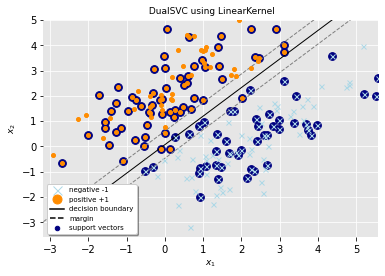

In [80]:
grid = GridSearchCV(DualSVC(loss=hinge, 
                            kernel=LinearKernel(), 
                            optimizer=AdaGrad, 
                            max_iter=10000, 
                            learning_rate=1.),
                    param_grid={'C': [1, 10, 100],
                                'reg_intercept': [True, False]},
                    scoring=dual_accuracy_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=1,  # 'train_loss_history' is not thread safe
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

plot_svm_hyperplane(grid.best_estimator_, lin_X, lin_y)

In [81]:
linear_lagrangian_dual_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
linear_lagrangian_dual_svc_cv_results.sort_values(['dual'], inplace=True)
linear_lagrangian_dual_svc_cv_results.set_index(['dual', 'C'], inplace=True)
linear_lagrangian_dual_svc_cv_results.to_latex('./tex/experiments/linear_lagrangian_dual_l1_svc.tex', 
                                               caption='Lagrangian Dual linear $\protect \mathcal{L}_1$-SVC results', 
                                               label='linear_lagrangian_dual_l1_svc_cv_results', position='H')
linear_lagrangian_dual_svc_cv_results

fit_time  accuracy  n_iter  n_sv
dual       C                                     
reg_bias   1    11.693950     0.985   10000   115
           10   11.408689     0.985   10000   111
           100  10.577088     0.955   10000   108
unreg_bias 1    11.543887     0.985   10000    83
           10   10.894025     0.970   10000   108
           100  11.499404     0.985   10000   120

##### Nonlinear

Fitting 1 folds for each of 12 candidates, totalling 12 fits


/home/donato/Insync/donato.meoli.95@gmail.com/Google Drive/MachineLearning&ComputationalMathematics/optiml/optiml/ml/svm/_base.py:845: ConvergenceWarning: max_iter reached but the optimization has not converged yet
  warnings.warn('max_iter reached but the optimization has not converged yet',


     pcost       dcost       gap    pres   dres
 0: -9.2053e+01 -1.1372e+03  7e+03  4e+00  5e-14
 1: -4.5998e+01 -7.6139e+02  1e+03  5e-01  4e-14
 2: -7.7986e+00 -2.4674e+02  4e+02  1e-01  2e-14
 3: -3.3553e+00 -6.4615e+01  7e+01  2e-02  1e-14
 4: -7.4294e+00 -3.2326e+01  3e+01  6e-03  8e-15
 5: -9.0647e+00 -2.6698e+01  2e+01  4e-03  8e-15
 6: -1.0800e+01 -2.1571e+01  1e+01  2e-03  7e-15
 7: -1.1850e+01 -1.8152e+01  7e+00  9e-04  7e-15
 8: -1.2378e+01 -1.6737e+01  5e+00  5e-04  7e-15
 9: -1.3172e+01 -1.5042e+01  2e+00  1e-04  8e-15
10: -1.3441e+01 -1.4572e+01  1e+00  2e-05  8e-15
11: -1.3769e+01 -1.4127e+01  4e-01  6e-06  8e-15
12: -1.3858e+01 -1.4005e+01  1e-01  2e-06  8e-15
13: -1.3915e+01 -1.3935e+01  2e-02  9e-08  9e-15
14: -1.3924e+01 -1.3925e+01  4e-04  1e-09  9e-15
15: -1.3924e+01 -1.3924e+01  6e-06  2e-11  8e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -9.2053e+01 -1.1372e+03  7e+03  4e+00  5e-14
 1: -4.5998e+01 -7.6139e+02  1e+03  5e-01  4e-1

/home/donato/Insync/donato.meoli.95@gmail.com/Google Drive/MachineLearning&ComputationalMathematics/optiml/optiml/ml/svm/_base.py:845: ConvergenceWarning: max_iter reached but the optimization has not converged yet
  warnings.warn('max_iter reached but the optimization has not converged yet',


     pcost       dcost       gap    pres   dres
 0: -9.2053e+01 -1.1373e+03  7e+03  4e+00  4e-14
 1: -4.6018e+01 -7.6154e+02  1e+03  5e-01  3e-14
 2: -7.8334e+00 -2.4722e+02  4e+02  1e-01  2e-14
 3: -3.3412e+00 -6.4866e+01  8e+01  2e-02  1e-14
 4: -7.3940e+00 -3.2487e+01  3e+01  6e-03  7e-15
 5: -9.0535e+00 -2.6660e+01  2e+01  4e-03  7e-15
 6: -1.0746e+01 -2.1670e+01  1e+01  2e-03  5e-15
 7: -1.1801e+01 -1.8272e+01  7e+00  1e-03  5e-15
 8: -1.2309e+01 -1.6820e+01  5e+00  5e-04  5e-15
 9: -1.3089e+01 -1.5181e+01  2e+00  1e-04  5e-15
10: -1.3392e+01 -1.4664e+01  1e+00  5e-05  5e-15
11: -1.3765e+01 -1.4101e+01  3e-01  7e-06  6e-15
12: -1.3870e+01 -1.3964e+01  9e-02  2e-06  6e-15
13: -1.3905e+01 -1.3920e+01  1e-02  4e-08  6e-15
14: -1.3912e+01 -1.3912e+01  3e-04  5e-10  6e-15
15: -1.3912e+01 -1.3912e+01  5e-06  8e-12  6e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -9.2053e+01 -1.1373e+03  7e+03  4e+00  4e-14
 1: -4.6018e+01 -7.6154e+02  1e+03  5e-01  3e-1

/home/donato/Insync/donato.meoli.95@gmail.com/Google Drive/MachineLearning&ComputationalMathematics/optiml/optiml/ml/svm/_base.py:845: ConvergenceWarning: max_iter reached but the optimization has not converged yet
  warnings.warn('max_iter reached but the optimization has not converged yet',


     pcost       dcost       gap    pres   dres
 0: -1.8456e+01 -6.2306e+02  3e+03  2e+00  6e-15
 1: -3.2432e+00 -3.0523e+02  4e+02  1e-01  7e-15
 2: -1.1272e+01 -5.0456e+01  4e+01  9e-03  7e-15
 3: -1.4888e+01 -3.9818e+01  3e+01  5e-03  5e-15
 4: -1.8383e+01 -3.0598e+01  1e+01  2e-03  5e-15
 5: -1.9445e+01 -2.8739e+01  9e+00  1e-03  4e-15
 6: -2.0608e+01 -2.6368e+01  6e+00  6e-04  5e-15
 7: -2.1181e+01 -2.5269e+01  4e+00  4e-04  5e-15
 8: -2.1791e+01 -2.3904e+01  2e+00  1e-04  5e-15
 9: -2.2288e+01 -2.3032e+01  7e-01  1e-05  6e-15
10: -2.2506e+01 -2.2736e+01  2e-01  6e-07  6e-15
11: -2.2599e+01 -2.2621e+01  2e-02  3e-08  6e-15
12: -2.2608e+01 -2.2610e+01  2e-03  3e-10  6e-15
13: -2.2609e+01 -2.2609e+01  1e-04  1e-11  6e-15
14: -2.2609e+01 -2.2609e+01  4e-06  4e-13  6e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.8456e+01 -6.2306e+02  3e+03  2e+00  6e-15
 1: -3.2432e+00 -3.0523e+02  4e+02  1e-01  7e-15
 2: -1.1272e+01 -5.0456e+01  4e+01  9e-03  7e-1

/home/donato/Insync/donato.meoli.95@gmail.com/Google Drive/MachineLearning&ComputationalMathematics/optiml/optiml/ml/svm/_base.py:845: ConvergenceWarning: max_iter reached but the optimization has not converged yet
  warnings.warn('max_iter reached but the optimization has not converged yet',


     pcost       dcost       gap    pres   dres
 0: -1.8456e+01 -6.2326e+02  3e+03  2e+00  2e-15
 1: -3.2373e+00 -3.0540e+02  4e+02  1e-01  2e-15
 2: -1.1264e+01 -5.0506e+01  4e+01  9e-03  2e-15
 3: -1.4890e+01 -3.9817e+01  3e+01  5e-03  2e-15
 4: -1.8386e+01 -3.0591e+01  1e+01  2e-03  2e-15
 5: -1.9452e+01 -2.8727e+01  9e+00  1e-03  1e-15
 6: -2.0625e+01 -2.6332e+01  6e+00  6e-04  1e-15
 7: -2.1192e+01 -2.5243e+01  4e+00  4e-04  1e-15
 8: -2.1801e+01 -2.3887e+01  2e+00  1e-04  2e-15
 9: -2.2294e+01 -2.3024e+01  7e-01  1e-05  2e-15
10: -2.2509e+01 -2.2731e+01  2e-01  5e-07  2e-15
11: -2.2599e+01 -2.2621e+01  2e-02  3e-08  2e-15
12: -2.2608e+01 -2.2610e+01  2e-03  6e-11  2e-15
13: -2.2609e+01 -2.2609e+01  6e-05  1e-12  2e-15
14: -2.2609e+01 -2.2609e+01  1e-06  3e-14  2e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.8456e+01 -6.2326e+02  3e+03  2e+00  2e-15
 1: -3.2373e+00 -3.0540e+02  4e+02  1e-01  2e-15
 2: -1.1264e+01 -5.0506e+01  4e+01  9e-03  2e-1

/home/donato/Insync/donato.meoli.95@gmail.com/Google Drive/MachineLearning&ComputationalMathematics/optiml/optiml/ml/svm/_base.py:845: ConvergenceWarning: max_iter reached but the optimization has not converged yet
  warnings.warn('max_iter reached but the optimization has not converged yet',


     pcost       dcost       gap    pres   dres
 0: -3.2433e+02 -4.4362e+04  2e+05  1e+00  2e-13
 1:  2.7968e+02 -1.9840e+04  3e+04  2e-01  2e-13
 2:  5.3417e+02 -4.3472e+03  7e+03  4e-02  1e-13
 3:  2.2350e+02 -6.4203e+02  9e+02  2e-03  6e-14
 4:  2.5081e+01 -6.6799e+01  9e+01  2e-05  2e-14
 5:  4.1551e-01 -2.7994e+01  3e+01  4e-06  1e-14
 6: -3.6584e+00 -3.1370e+01  3e+01  4e-06  1e-14
 7: -8.0856e+00 -3.3392e+01  3e+01  3e-06  2e-14
 8: -7.0964e+00 -3.2393e+01  3e+01  3e-06  2e-14
 9: -1.0565e+01 -3.3441e+01  2e+01  2e-06  1e-14
10: -1.5867e+01 -3.0364e+01  1e+01  7e-07  1e-14
11: -1.8551e+01 -2.6865e+01  8e+00  4e-07  1e-14
12: -2.0962e+01 -2.3932e+01  3e+00  7e-09  2e-14
13: -2.2201e+01 -2.2381e+01  2e-01  2e-16  2e-14
14: -2.2284e+01 -2.2286e+01  2e-03  2e-16  2e-14
15: -2.2285e+01 -2.2285e+01  2e-05  2e-16  2e-14
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -3.2433e+02 -4.4362e+04  2e+05  1e+00  2e-13
 1:  2.7968e+02 -1.9840e+04  3e+04  2e-01  2e-1

/home/donato/Insync/donato.meoli.95@gmail.com/Google Drive/MachineLearning&ComputationalMathematics/optiml/optiml/ml/svm/_base.py:845: ConvergenceWarning: max_iter reached but the optimization has not converged yet
  warnings.warn('max_iter reached but the optimization has not converged yet',


     pcost       dcost       gap    pres   dres
 0: -3.2462e+02 -4.4368e+04  2e+05  1e+00  2e-13
 1:  2.7858e+02 -1.9852e+04  3e+04  2e-01  2e-13
 2:  5.3385e+02 -4.3510e+03  7e+03  4e-02  1e-13
 3:  2.2391e+02 -6.4519e+02  9e+02  2e-03  5e-14
 4:  2.5229e+01 -6.7056e+01  9e+01  2e-05  2e-14
 5:  5.0968e-01 -2.8173e+01  3e+01  5e-06  1e-14
 6: -3.7887e+00 -3.1509e+01  3e+01  4e-06  1e-14
 7: -8.0327e+00 -3.3400e+01  3e+01  3e-06  1e-14
 8: -7.5286e+00 -3.2861e+01  3e+01  3e-06  1e-14
 9: -9.7628e+00 -3.2030e+01  2e+01  2e-06  1e-14
10: -8.6755e+00 -3.1057e+01  2e+01  2e-06  9e-15
11: -9.4623e+00 -3.1077e+01  2e+01  2e-06  9e-15
12: -1.1108e+01 -3.2530e+01  2e+01  2e-06  9e-15
13: -1.4751e+01 -2.9779e+01  2e+01  1e-06  1e-14
14: -1.8356e+01 -2.6717e+01  8e+00  4e-07  1e-14
15: -2.1056e+01 -2.3686e+01  3e+00  1e-08  1e-14
16: -2.2210e+01 -2.2289e+01  8e-02  1e-10  1e-14
17: -2.2246e+01 -2.2247e+01  8e-04  1e-12  1e-14
18: -2.2246e+01 -2.2246e+01  8e-06  1e-14  1e-14
Optimal solution foun

/home/donato/Insync/donato.meoli.95@gmail.com/Google Drive/MachineLearning&ComputationalMathematics/optiml/optiml/ml/svm/_base.py:845: ConvergenceWarning: max_iter reached but the optimization has not converged yet
  warnings.warn('max_iter reached but the optimization has not converged yet',


     pcost       dcost       gap    pres   dres
 0:  6.8486e+02 -1.5482e+04  3e+04  4e-01  3e-14
 1:  7.5494e+02 -1.9900e+03  3e+03  4e-03  4e-14
 2:  9.3125e+01 -2.2870e+02  3e+02  7e-05  3e-14
 3: -5.9896e+00 -4.7273e+01  4e+01  2e-16  1e-14
 4: -1.3242e+01 -3.5960e+01  2e+01  2e-16  7e-15
 5: -1.6308e+01 -3.7970e+01  2e+01  2e-16  9e-15
 6: -1.9720e+01 -3.6361e+01  2e+01  2e-16  1e-14
 7: -1.9313e+01 -3.5942e+01  2e+01  3e-16  9e-15
 8: -2.0956e+01 -3.4951e+01  1e+01  3e-16  9e-15
 9: -2.1464e+01 -3.5391e+01  1e+01  3e-16  9e-15
10: -2.1255e+01 -3.5069e+01  1e+01  3e-16  9e-15
11: -2.4853e+01 -3.4488e+01  1e+01  2e-16  1e-14
12: -2.7439e+01 -3.0652e+01  3e+00  2e-16  1e-14
13: -2.8827e+01 -2.8941e+01  1e-01  2e-16  1e-14
14: -2.8879e+01 -2.8881e+01  2e-03  2e-16  1e-14
15: -2.8880e+01 -2.8880e+01  3e-05  2e-16  1e-14
16: -2.8880e+01 -2.8880e+01  4e-07  2e-16  1e-14
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  6.8486e+02 -1.5482e+04  3e+04  4e-01  3e-1

/home/donato/Insync/donato.meoli.95@gmail.com/Google Drive/MachineLearning&ComputationalMathematics/optiml/optiml/ml/svm/_base.py:845: ConvergenceWarning: max_iter reached but the optimization has not converged yet
  warnings.warn('max_iter reached but the optimization has not converged yet',


     pcost       dcost       gap    pres   dres
 0:  6.8484e+02 -1.5493e+04  3e+04  4e-01  1e-14
 1:  7.5551e+02 -1.9923e+03  3e+03  4e-03  1e-14
 2:  9.3148e+01 -2.2877e+02  3e+02  7e-05  1e-14
 3: -5.9875e+00 -4.7278e+01  4e+01  1e-14  4e-15
 4: -1.3243e+01 -3.5954e+01  2e+01  1e-14  3e-15
 5: -1.6311e+01 -3.7967e+01  2e+01  3e-15  3e-15
 6: -1.9721e+01 -3.6359e+01  2e+01  9e-15  3e-15
 7: -1.9314e+01 -3.5941e+01  2e+01  9e-16  3e-15
 8: -2.0956e+01 -3.4950e+01  1e+01  2e-14  3e-15
 9: -2.1463e+01 -3.5389e+01  1e+01  2e-15  3e-15
10: -2.1252e+01 -3.5066e+01  1e+01  2e-14  3e-15
11: -2.4843e+01 -3.4494e+01  1e+01  1e-14  3e-15
12: -2.7435e+01 -3.0654e+01  3e+00  4e-15  4e-15
13: -2.8826e+01 -2.8941e+01  1e-01  1e-15  4e-15
14: -2.8878e+01 -2.8880e+01  2e-03  2e-14  5e-15
15: -2.8879e+01 -2.8879e+01  3e-05  7e-15  4e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  6.8484e+02 -1.5493e+04  3e+04  4e-01  1e-14
 1:  7.5551e+02 -1.9923e+03  3e+03  4e-03  1e-1

/home/donato/Insync/donato.meoli.95@gmail.com/Google Drive/MachineLearning&ComputationalMathematics/optiml/optiml/ml/svm/_base.py:845: ConvergenceWarning: max_iter reached but the optimization has not converged yet
  warnings.warn('max_iter reached but the optimization has not converged yet',


     pcost       dcost       gap    pres   dres
 0:  1.3729e+04 -3.7443e+06  1e+07  1e+00  2e-12
 1:  5.0373e+04 -1.5365e+06  3e+06  2e-01  2e-12
 2:  5.1920e+04 -3.2666e+05  5e+05  4e-02  1e-12
 3:  1.9778e+04 -4.2171e+04  7e+04  2e-03  5e-13
 4:  3.1460e+03 -3.7179e+03  7e+03  9e-06  2e-13
 5:  4.1921e+02 -5.7338e+02  1e+03  2e-16  9e-14
 6:  4.5202e+01 -9.5337e+01  1e+02  2e-16  3e-14
 7:  9.0539e-01 -2.7339e+01  3e+01  2e-16  1e-14
 8: -5.8000e+00 -3.3036e+01  3e+01  3e-16  2e-14
 9: -1.5032e+01 -3.1207e+01  2e+01  2e-16  2e-14
10: -2.2205e+01 -2.6258e+01  4e+00  2e-16  2e-14
11: -2.3604e+01 -2.4965e+01  1e+00  2e-16  3e-14
12: -2.4032e+01 -2.4687e+01  7e-01  2e-16  3e-14
13: -2.4331e+01 -2.4350e+01  2e-02  2e-16  3e-14
14: -2.4340e+01 -2.4341e+01  2e-04  2e-16  3e-14
15: -2.4340e+01 -2.4340e+01  2e-06  2e-16  3e-14
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  1.3729e+04 -3.7443e+06  1e+07  1e+00  2e-12
 1:  5.0373e+04 -1.5365e+06  3e+06  2e-01  2e-1

/home/donato/Insync/donato.meoli.95@gmail.com/Google Drive/MachineLearning&ComputationalMathematics/optiml/optiml/ml/svm/_base.py:845: ConvergenceWarning: max_iter reached but the optimization has not converged yet
  warnings.warn('max_iter reached but the optimization has not converged yet',


     pcost       dcost       gap    pres   dres
 0:  1.3700e+04 -3.7448e+06  1e+07  1e+00  2e-12
 1:  5.0279e+04 -1.5375e+06  3e+06  2e-01  2e-12
 2:  5.1892e+04 -3.2678e+05  5e+05  4e-02  9e-13
 3:  1.9804e+04 -4.2367e+04  7e+04  2e-03  4e-13
 4:  3.1558e+03 -3.7340e+03  7e+03  1e-05  2e-13
 5:  4.2066e+02 -5.7511e+02  1e+03  8e-14  8e-14
 6:  4.5405e+01 -9.5589e+01  1e+02  1e-14  3e-14
 7:  1.0126e+00 -2.7509e+01  3e+01  1e-14  1e-14
 8: -5.8768e+00 -3.2890e+01  3e+01  3e-15  1e-14
 9: -1.4647e+01 -3.1267e+01  2e+01  2e-16  1e-14
10: -2.1889e+01 -2.6337e+01  4e+00  9e-15  1e-14
11: -2.3449e+01 -2.4981e+01  2e+00  1e-15  1e-14
12: -2.3955e+01 -2.4677e+01  7e-01  1e-14  1e-14
13: -2.4284e+01 -2.4307e+01  2e-02  2e-14  1e-14
14: -2.4295e+01 -2.4295e+01  2e-04  2e-14  1e-14
15: -2.4295e+01 -2.4295e+01  2e-06  9e-15  2e-14
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  1.3700e+04 -3.7448e+06  1e+07  1e+00  2e-12
 1:  5.0279e+04 -1.5375e+06  3e+06  2e-01  2e-1

/home/donato/Insync/donato.meoli.95@gmail.com/Google Drive/MachineLearning&ComputationalMathematics/optiml/optiml/ml/svm/_base.py:845: ConvergenceWarning: max_iter reached but the optimization has not converged yet
  warnings.warn('max_iter reached but the optimization has not converged yet',


     pcost       dcost       gap    pres   dres
 0:  7.8491e+04 -1.0871e+06  2e+06  3e-01  3e-13
 1:  6.2018e+04 -1.4437e+05  2e+05  2e-02  3e-13
 2:  1.2071e+04 -1.5119e+04  3e+04  2e-04  2e-13
 3:  1.6545e+03 -2.2000e+03  4e+03  2e-16  9e-14
 4:  1.9469e+02 -3.5138e+02  5e+02  2e-16  3e-14
 5:  6.0728e+00 -6.9264e+01  8e+01  2e-16  2e-14
 6: -1.1295e+01 -3.6030e+01  2e+01  2e-16  7e-15
 7: -1.6299e+01 -3.9527e+01  2e+01  3e-16  1e-14
 8: -2.5653e+01 -3.3951e+01  8e+00  2e-16  1e-14
 9: -2.8529e+01 -3.1679e+01  3e+00  2e-16  1e-14
10: -2.9893e+01 -3.0156e+01  3e-01  2e-16  2e-14
11: -3.0017e+01 -3.0020e+01  3e-03  2e-16  2e-14
12: -3.0018e+01 -3.0018e+01  3e-05  2e-16  2e-14
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  7.8491e+04 -1.0871e+06  2e+06  3e-01  3e-13
 1:  6.2018e+04 -1.4437e+05  2e+05  2e-02  3e-13
 2:  1.2071e+04 -1.5119e+04  3e+04  2e-04  2e-13
 3:  1.6545e+03 -2.2000e+03  4e+03  2e-16  9e-14
 4:  1.9469e+02 -3.5138e+02  5e+02  2e-16  3e-1

/home/donato/Insync/donato.meoli.95@gmail.com/Google Drive/MachineLearning&ComputationalMathematics/optiml/optiml/ml/svm/_base.py:845: ConvergenceWarning: max_iter reached but the optimization has not converged yet
  warnings.warn('max_iter reached but the optimization has not converged yet',


     pcost       dcost       gap    pres   dres
 0:  7.8489e+04 -1.0880e+06  2e+06  3e-01  1e-13
 1:  6.2071e+04 -1.4461e+05  2e+05  2e-02  1e-13
 2:  1.2090e+04 -1.5162e+04  3e+04  2e-04  7e-14
 3:  1.6574e+03 -2.2033e+03  4e+03  7e-14  3e-14
 4:  1.9507e+02 -3.5191e+02  5e+02  4e-14  1e-14
 5:  6.1205e+00 -6.9347e+01  8e+01  3e-14  5e-15
 6: -1.1294e+01 -3.6017e+01  2e+01  3e-15  3e-15
 7: -1.6293e+01 -3.9519e+01  2e+01  1e-14  4e-15
 8: -2.5667e+01 -3.3944e+01  8e+00  7e-15  4e-15
 9: -2.8539e+01 -3.1668e+01  3e+00  5e-15  5e-15
10: -2.9894e+01 -3.0155e+01  3e-01  2e-14  6e-15
11: -3.0017e+01 -3.0020e+01  3e-03  1e-14  6e-15
12: -3.0018e+01 -3.0018e+01  3e-05  2e-15  6e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  7.8489e+04 -1.0880e+06  2e+06  3e-01  1e-13
 1:  6.2071e+04 -1.4461e+05  2e+05  2e-02  1e-13
 2:  1.2090e+04 -1.5162e+04  3e+04  2e-04  7e-14
 3:  1.6574e+03 -2.2033e+03  4e+03  7e-14  3e-14
 4:  1.9507e+02 -3.5191e+02  5e+02  4e-14  1e-1

/home/donato/Insync/donato.meoli.95@gmail.com/Google Drive/MachineLearning&ComputationalMathematics/optiml/optiml/ml/svm/_base.py:845: ConvergenceWarning: max_iter reached but the optimization has not converged yet
  warnings.warn('max_iter reached but the optimization has not converged yet',


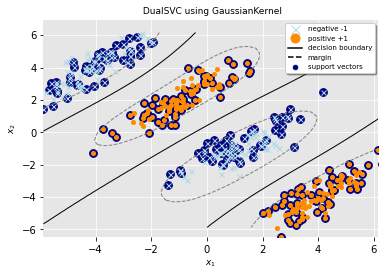

In [82]:
grid = GridSearchCV(DualSVC(loss=hinge, 
                            optimizer=AdaGrad, 
                            max_iter=10000, 
                            learning_rate=1.),
                    param_grid={'C': [1, 10, 100],
                                'kernel': [PolyKernel(degree=3, coef0=1, gamma='scale'), 
                                           GaussianKernel(gamma='scale')],
                                'reg_intercept': [True, False]},
                    scoring=dual_accuracy_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=1,  # 'train_loss_history' is not thread safe
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(nonlin_X, nonlin_y)

plot_svm_hyperplane(grid.best_estimator_, nonlin_X, nonlin_y)

In [83]:
nonlinear_lagrangian_dual_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
nonlinear_lagrangian_dual_svc_cv_results.sort_values(['dual', 'kernel'], inplace=True)
nonlinear_lagrangian_dual_svc_cv_results.set_index(['dual', 'kernel', 'C'], inplace=True)
nonlinear_lagrangian_dual_svc_cv_results.to_latex('./tex/experiments/nonlinear_lagrangian_dual_l1_svc.tex', 
                                                  caption='Lagrangian Dual nonlinear $\protect \mathcal{L}_1$-SVC results', 
                                                  label='nonlinear_lagrangian_dual_l1_svc_cv_results', position='H')
nonlinear_lagrangian_dual_svc_cv_results

fit_time  accuracy  n_iter  n_sv
dual       kernel C                                     
reg_bias   poly   1    33.831825    0.7475   10000   229
                  10   31.242017    0.9150   10000   261
                  100  34.082438    0.9950   10000   203
           rbf    1    32.117312    1.0000   10000   217
                  10   34.444916    1.0000   10000   203
                  100  34.043783    1.0000   10000   196
unreg_bias poly   1    32.926910    0.7500   10000   175
                  10   33.748768    0.7650   10000   139
                  100  32.885811    0.7950   10000   188
           rbf    1    32.245228    1.0000   10000   231
                  10   30.489399    1.0000   10000   210
                  100  29.613943    1.0000   10000   232

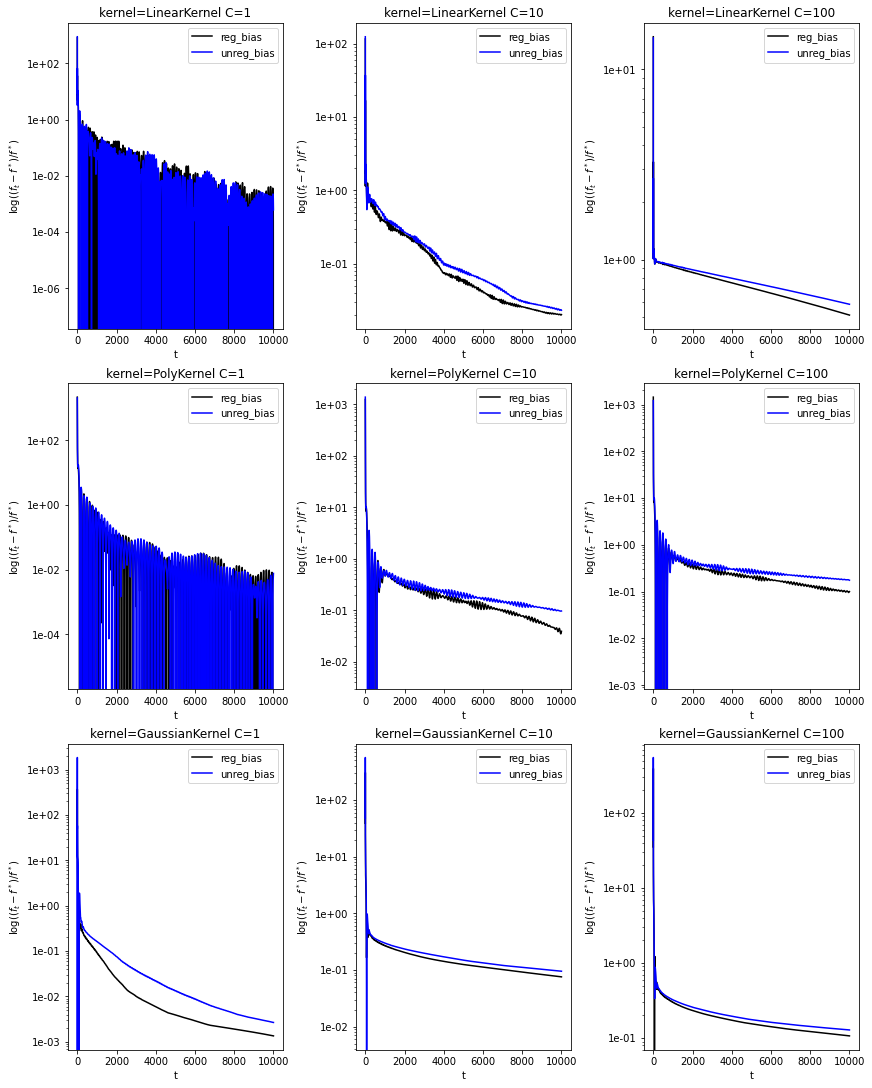

In [84]:
colors = {'reg_bias': ('k', 'regularized bias')
          'unreg_bias': ('b', 'unregularized bias')}
axes = plt.figure(figsize=(12, 15), constrained_layout=True).subplots(3, 3)
for dual, _dict1 in train_loss_history.items():
    for (kernel, _dict2), row_ax in zip(_dict1.items(), axes):
        for (C, history), loss in zip(_dict2.items(), row_ax):
            loss.plot(history, color=colors[dual][0], legend=colors[dual][1])
            loss.set_title('kernel={} C={:d}'.format(kernel, C))
            loss.set_xlabel('t')
            loss.set_yscale('log')
            loss.set_ylabel('$\log((f_t - f^*) / f^*)$')
            loss.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
            loss.legend().get_frame().set_facecolor('white')
plt.savefig('./tex/img/lagrangian_dual_l1_svc_loss_history.png')

## Squared Hinge loss

### Primal formulation

In [85]:
from optiml.ml.svm import PrimalSVC
from optiml.ml.svm.losses import squared_hinge
from optiml.ml.utils import plot_svm_hyperplane

from optiml.opti.unconstrained.stochastic import StochasticGradientDescent
from optiml.opti.utils import plot_surface_contour, plot_trajectory_optimization

from sklearn.svm import LinearSVC as SkLinearSVC
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

In [86]:
train_loss_history = defaultdict(dict)

def primal_accuracy_scorer(svc, X, y):
    
    if hasattr(svc, 'train_loss_history'):
        
        from optiml.ml.svm import DualSVC
        from optiml.ml.svm.kernels import LinearKernel
        
        dual_svc = DualSVC(loss=squared_hinge, 
                           kernel=LinearKernel(), 
                           C=svc.C, 
                           reg_intercept=True, 
                           optimizer='cvxopt').fit(lin_X, lin_y)
        f_star = np.full_like(svc.train_loss_history, svc.loss(np.append(dual_svc.coef_, dual_svc.intercept_)))
        # (f_t - f^*) / f^*
        train_loss_history[svc.momentum_type][svc.C] = np.divide((svc.train_loss_history - f_star), 
                                                                np.maximum(abs(f_star), 1))
        
    return {'accuracy': svc.score(X, y), 
            'n_iter': svc.n_iter_ if isinstance(svc, SkLinearSVC) else svc.optimizer.iter + 1,  # starts from 0
            'n_sv': len(np.argwhere(np.abs(svc.decision_function(lin_X)) <= 1).ravel())}

Fitting 1 folds for each of 3 candidates, totalling 3 fits
     pcost       dcost       gap    pres   dres
 0: -2.1621e+01 -4.9136e+01  5e+02  2e+01  2e+00
 1: -2.7460e+01 -2.8540e+01  7e+01  3e+00  2e-01
 2: -1.5534e+01 -1.3489e+01  8e+00  4e-01  3e-02
 3: -1.1267e+01 -1.1570e+01  1e+00  2e-02  2e-03
 4: -1.1197e+01 -1.1253e+01  9e-02  1e-03  9e-05
 5: -1.1227e+01 -1.1231e+01  5e-03  4e-05  3e-06
 6: -1.1230e+01 -1.1230e+01  2e-04  6e-07  5e-08
 7: -1.1230e+01 -1.1230e+01  2e-06  6e-09  5e-10
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.1621e+01 -4.9136e+01  5e+02  2e+01  2e+00
 1: -2.7460e+01 -2.8540e+01  7e+01  3e+00  2e-01
 2: -1.5534e+01 -1.3489e+01  8e+00  4e-01  3e-02
 3: -1.1267e+01 -1.1570e+01  1e+00  2e-02  2e-03
 4: -1.1197e+01 -1.1253e+01  9e-02  1e-03  9e-05
 5: -1.1227e+01 -1.1231e+01  5e-03  4e-05  3e-06
 6: -1.1230e+01 -1.1230e+01  2e-04  6e-07  5e-08
 7: -1.1230e+01 -1.1230e+01  2e-06  6e-09  5e-10
Optimal solution found.
     pcost   

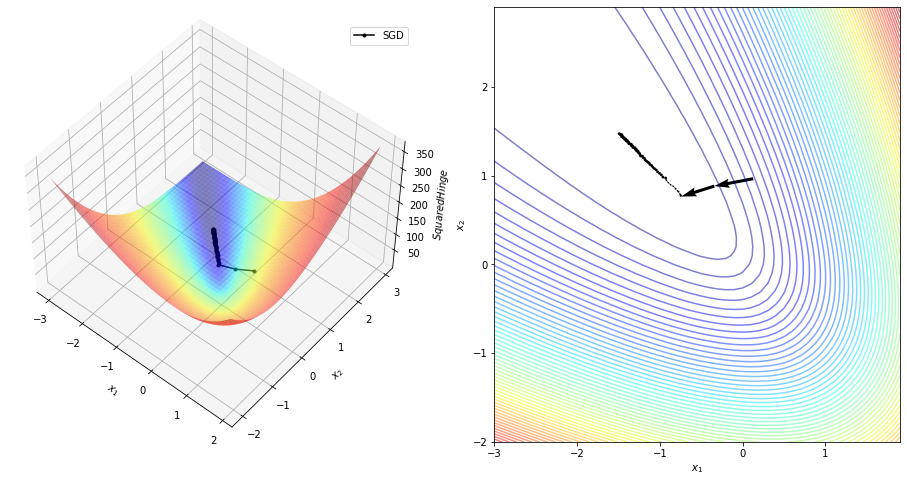

In [87]:
grid = GridSearchCV(PrimalSVC(loss=squared_hinge, 
                              optimizer=StochasticGradientDescent, 
                              learning_rate=0.02, 
                              momentum_type='none', 
                              early_stopping=True, 
                              tol=1e-8, 
                              random_state=123456),
                    param_grid={'C': [1, 10, 100]},
                    scoring=primal_accuracy_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=1,  # 'train_loss_history' is not thread safe
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

grid.best_estimator_.loss.X = grid.best_estimator_.loss.X[:, :-1]  # remove the intercept column to plot in 2D
squared_hinge_loss = plot_surface_contour(grid.best_estimator_.loss, 
                                          x_min=-3, x_max=2, y_min=-2, y_max=3)
squared_hinge_loss_opt = plot_trajectory_optimization(squared_hinge_loss, 
                                                      grid.best_estimator_.optimizer, 
                                                      color='k', 
                                                      label='SGD')

In [88]:
none_primal_svc_squared_hinge_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
none_primal_svc_squared_hinge_cv_results.insert(0, 'solver', 'sgd')
none_primal_svc_squared_hinge_cv_results.insert(1, 'momentum', 'none')
none_primal_svc_squared_hinge_cv_results.set_index(['solver', 'momentum', 'C'], inplace=True)
none_primal_svc_squared_hinge_cv_results

fit_time  accuracy  n_iter  n_sv
solver momentum C                                    
sgd    none     1    0.174289     0.980     433    24
                10   0.076226     0.985      57    21
                100  0.015678     0.980      10     7

Fitting 1 folds for each of 3 candidates, totalling 3 fits
     pcost       dcost       gap    pres   dres
 0: -2.1621e+01 -4.9136e+01  5e+02  2e+01  2e+00
 1: -2.7460e+01 -2.8540e+01  7e+01  3e+00  2e-01
 2: -1.5534e+01 -1.3489e+01  8e+00  4e-01  3e-02
 3: -1.1267e+01 -1.1570e+01  1e+00  2e-02  2e-03
 4: -1.1197e+01 -1.1253e+01  9e-02  1e-03  9e-05
 5: -1.1227e+01 -1.1231e+01  5e-03  4e-05  3e-06
 6: -1.1230e+01 -1.1230e+01  2e-04  6e-07  5e-08
 7: -1.1230e+01 -1.1230e+01  2e-06  6e-09  5e-10
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.1621e+01 -4.9136e+01  5e+02  2e+01  2e+00
 1: -2.7460e+01 -2.8540e+01  7e+01  3e+00  2e-01
 2: -1.5534e+01 -1.3489e+01  8e+00  4e-01  3e-02
 3: -1.1267e+01 -1.1570e+01  1e+00  2e-02  2e-03
 4: -1.1197e+01 -1.1253e+01  9e-02  1e-03  9e-05
 5: -1.1227e+01 -1.1231e+01  5e-03  4e-05  3e-06
 6: -1.1230e+01 -1.1230e+01  2e-04  6e-07  5e-08
 7: -1.1230e+01 -1.1230e+01  2e-06  6e-09  5e-10
Optimal solution found.
     pcost   

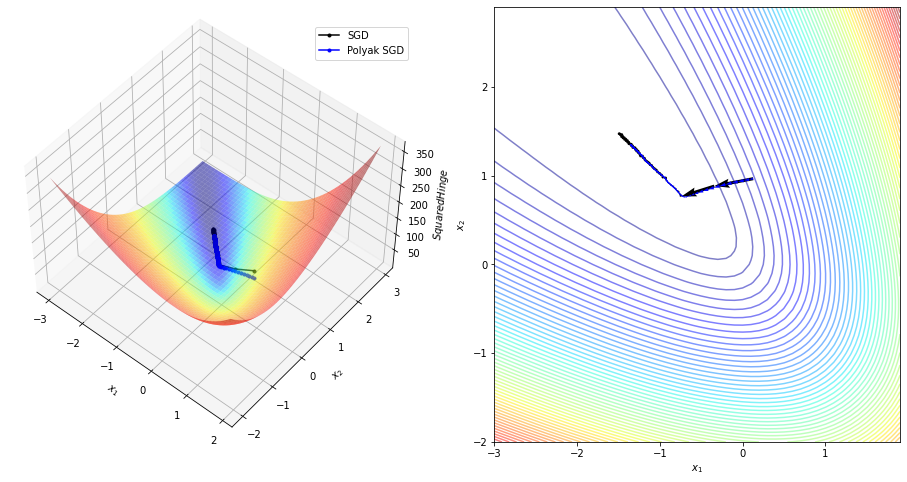

In [89]:
grid = GridSearchCV(PrimalSVC(loss=squared_hinge, 
                              optimizer=StochasticGradientDescent, 
                              learning_rate=0.02, 
                              momentum_type='polyak', 
                              momentum=0.4, 
                              early_stopping=True, 
                              tol=1e-8, 
                              random_state=123456),
                    param_grid={'C': [1, 10, 100]},
                    scoring=primal_accuracy_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=1,  # 'train_loss_history' is not thread safe
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

squared_hinge_loss_opt = plot_trajectory_optimization(squared_hinge_loss_opt, 
                                                      grid.best_estimator_.optimizer, 
                                                      color='b', 
                                                      label='Polyak SGD')
squared_hinge_loss_opt

In [90]:
polyak_primal_svc_squared_hinge_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
polyak_primal_svc_squared_hinge_cv_results.insert(0, 'solver', 'sgd')
polyak_primal_svc_squared_hinge_cv_results.insert(1, 'momentum', 'polyak')
polyak_primal_svc_squared_hinge_cv_results.set_index(['solver', 'momentum', 'C'], inplace=True)
polyak_primal_svc_squared_hinge_cv_results

fit_time  accuracy  n_iter  n_sv
solver momentum C                                    
sgd    polyak   1    0.101484     0.985     271    25
                10   0.044780     0.985      31    23
                100  0.028770     0.980      12     3

Fitting 1 folds for each of 3 candidates, totalling 3 fits
     pcost       dcost       gap    pres   dres
 0: -2.1621e+01 -4.9136e+01  5e+02  2e+01  2e+00
 1: -2.7460e+01 -2.8540e+01  7e+01  3e+00  2e-01
 2: -1.5534e+01 -1.3489e+01  8e+00  4e-01  3e-02
 3: -1.1267e+01 -1.1570e+01  1e+00  2e-02  2e-03
 4: -1.1197e+01 -1.1253e+01  9e-02  1e-03  9e-05
 5: -1.1227e+01 -1.1231e+01  5e-03  4e-05  3e-06
 6: -1.1230e+01 -1.1230e+01  2e-04  6e-07  5e-08
 7: -1.1230e+01 -1.1230e+01  2e-06  6e-09  5e-10
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.1621e+01 -4.9136e+01  5e+02  2e+01  2e+00
 1: -2.7460e+01 -2.8540e+01  7e+01  3e+00  2e-01
 2: -1.5534e+01 -1.3489e+01  8e+00  4e-01  3e-02
 3: -1.1267e+01 -1.1570e+01  1e+00  2e-02  2e-03
 4: -1.1197e+01 -1.1253e+01  9e-02  1e-03  9e-05
 5: -1.1227e+01 -1.1231e+01  5e-03  4e-05  3e-06
 6: -1.1230e+01 -1.1230e+01  2e-04  6e-07  5e-08
 7: -1.1230e+01 -1.1230e+01  2e-06  6e-09  5e-10
Optimal solution found.
     pcost   

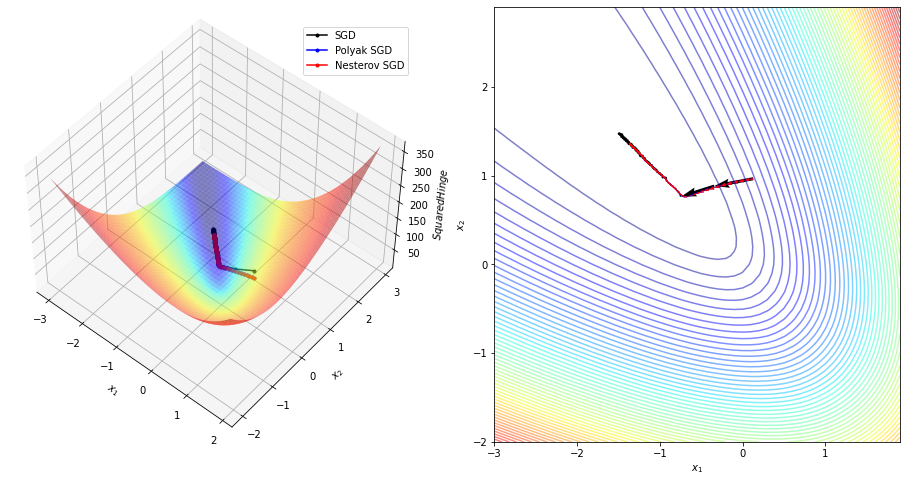

In [91]:
grid = GridSearchCV(PrimalSVC(loss=squared_hinge, 
                              optimizer=StochasticGradientDescent, 
                              learning_rate=0.02, 
                              momentum_type='nesterov', 
                              momentum=0.4, 
                              early_stopping=True, 
                              tol=1e-8, 
                              random_state=123456),
                    param_grid={'C': [1, 10, 100]},
                    scoring=primal_accuracy_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=1,  # 'train_loss_history' is not thread safe
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

squared_hinge_loss_opt = plot_trajectory_optimization(squared_hinge_loss_opt, 
                                                      grid.best_estimator_.optimizer, 
                                                      color='r', 
                                                      label='Nesterov SGD')
squared_hinge_loss_opt.savefig('./tex/img/l2_svc_loss.png')
squared_hinge_loss_opt

In [92]:
nesterov_primal_svc_squared_hinge_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
nesterov_primal_svc_squared_hinge_cv_results.insert(0, 'solver', 'sgd')
nesterov_primal_svc_squared_hinge_cv_results.insert(1, 'momentum', 'nesterov')
nesterov_primal_svc_squared_hinge_cv_results.set_index(['solver', 'momentum', 'C'], inplace=True)
nesterov_primal_svc_squared_hinge_cv_results

fit_time  accuracy  n_iter  n_sv
solver momentum C                                    
sgd    nesterov 1    0.124950     0.985     280    23
                10   0.045436     0.985      34    20
                100  0.008115     0.985      10     4

In [93]:
custom_primal_svc_squared_hinge_cv_results = none_primal_svc_squared_hinge_cv_results.append(
    polyak_primal_svc_squared_hinge_cv_results).append(
    nesterov_primal_svc_squared_hinge_cv_results)
custom_primal_svc_squared_hinge_cv_results

fit_time  accuracy  n_iter  n_sv
solver momentum C                                    
sgd    none     1    0.174289     0.980     433    24
                10   0.076226     0.985      57    21
                100  0.015678     0.980      10     7
       polyak   1    0.101484     0.985     271    25
                10   0.044780     0.985      31    23
                100  0.028770     0.980      12     3
       nesterov 1    0.124950     0.985     280    23
                10   0.045436     0.985      34    20
                100  0.008115     0.985      10     4

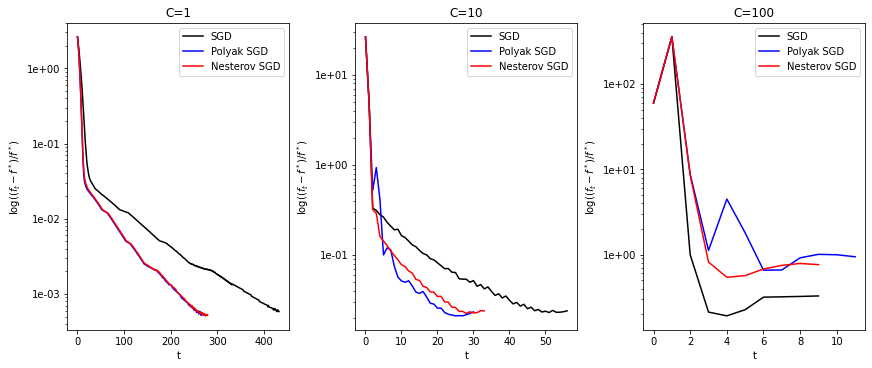

In [94]:
colors = {'none': ('k', 'SGD'),
          'polyak': ('b', 'Polyak SGD'),
          'nesterov': ('r', 'Nesterov SGD')}
axes = plt.figure(figsize=(12, 5), constrained_layout=True).subplots(1, 3)
for momentum, _dict in train_loss_history.items():
    for (C, history), loss in zip(_dict.items(), axes):
        loss.plot(history, color=colors[momentum][0], label=colors[momentum][1])
        loss.set_title('C={:d}'.format(C))
        loss.set_xlabel('t')
        loss.set_yscale('log')
        loss.set_ylabel('$\log((f_t - f^*) / f^*)$')
        loss.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
        loss.legend().get_frame().set_facecolor('white')
plt.savefig('./tex/img/l2_svc_loss_history.png')

In [95]:
grid = GridSearchCV(SkLinearSVC(loss='squared_hinge', 
                                random_state=123456),
                    param_grid={'C': [1, 10, 100]},
                    scoring=primal_accuracy_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

Fitting 1 folds for each of 3 candidates, totalling 3 fits


In [96]:
liblinear_primal_svc_squared_hinge_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
liblinear_primal_svc_squared_hinge_cv_results.insert(0, 'solver', 'liblinear')
liblinear_primal_svc_squared_hinge_cv_results.insert(1, 'momentum', '-')
liblinear_primal_svc_squared_hinge_cv_results.set_index(['solver', 'momentum', 'C'], inplace=True)
liblinear_primal_svc_squared_hinge_cv_results

fit_time  accuracy  n_iter  n_sv
solver    momentum C                                    
liblinear -        1    0.001608      0.98     563    25
                   10   0.002034      0.98    1000    19
                   100  0.001984      0.98    1000    21

In [97]:
primal_svc_squared_hinge_cv_results = custom_primal_svc_squared_hinge_cv_results.append(liblinear_primal_svc_squared_hinge_cv_results)
primal_svc_squared_hinge_cv_results.to_latex('./tex/experiments/primal_l2_svc.tex', 
                                             caption='Primal $\protect \mathcal{L}_2$-SVC results', 
                                             label='primal_l2_svc_cv_results', position='H')
primal_svc_squared_hinge_cv_results

fit_time  accuracy  n_iter  n_sv
solver    momentum C                                    
sgd       none     1    0.174289     0.980     433    24
                   10   0.076226     0.985      57    21
                   100  0.015678     0.980      10     7
          polyak   1    0.101484     0.985     271    25
                   10   0.044780     0.985      31    23
                   100  0.028770     0.980      12     3
          nesterov 1    0.124950     0.985     280    23
                   10   0.045436     0.985      34    20
                   100  0.008115     0.985      10     4
liblinear -        1    0.001608     0.980     563    25
                   10   0.002034     0.980    1000    19
                   100  0.001984     0.980    1000    21